## Time Series Prediction

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import copy
import math
import torch.nn.functional as F

### Download the data

In [2]:
#!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv --no-check-certificate

### Visualize the data

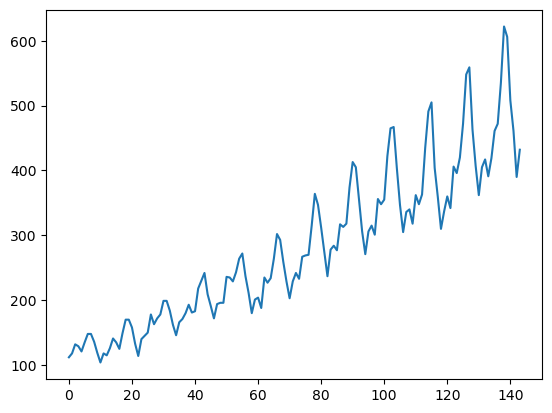

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')
plt.plot(timeseries)
plt.show()
df.head()

### Preparing data

In this case, the data preparation only includes the division of the entire data set into teaching validation and test parts. The entire data set must describe reality well and all three parts must describe the entire data set well.

In [4]:
train_size = int(len(timeseries) * 0.6)
valid_size = int(len(timeseries) * 0.2)
test_size = len(timeseries) - train_size - valid_size

train, valid, test = timeseries[:train_size], timeseries[train_size:train_size+valid_size],timeseries[train_size+valid_size:]


#### Transform a time series into a prediction dataset
Args:
- dataset: A numpy array of time series, first dimension is the time steps
- lookback: Size of window for prediction

In [5]:
def create_dataset(dataset, lookback):

    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [6]:
lookback = 5
X_train, y_train = create_dataset(train, lookback=lookback)
X_valid, y_valid = create_dataset(valid, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

torch.Size([81, 5, 1])
torch.Size([23, 5, 1])
torch.Size([25, 5, 1])


C:\Users\kovac\AppData\Local\Temp\ipykernel_19892\1069094615.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.tensor(X), torch.tensor(y)


### Models
- Recurrented layes generally: https://pytorch.org/docs/stable/nn.html#recurrent-layers
- RNN: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
<img src="files/Pics/RNN.png" width=450>
- GRU: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
<img src="files/Pics/GRU.png" width=450>
- LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
<img src="files/Pics/LSTM_Cell.png" width=450>
- Transformer (we will learn it on the next class): https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
<img src="files/Pics/A_development_of_natural_language_processing_tools.png" width=250>

In [7]:
class AirRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=50, num_layers=10, dropout=0.1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.linear(x)
        return x

In [8]:
class AirGRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=50, num_layers=1, dropout=0.1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear(x)
        return x

In [9]:
class AirLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=2, dropout=0.1, batch_first=True)
        self.linear = nn.Linear(32, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [10]:
class AirCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=lookback, out_channels=50, kernel_size=1, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.relu = nn.ReLU()
        self.sgm = nn.Sigmoid()
        self.flt = nn.Flatten()
        self.linear = nn.Linear(50, lookback)
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.flt(x)
        x = self.linear(x)
        return x

In [11]:
class AirANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(lookback,16)
        #self.act = nn.ReLU()
        self.act = nn.Sigmoid()
        self.linear2 = nn.Linear(16, lookback)
    def forward(self, x):
        x=x[:,:,0]
        x = self.linear1(x)
        x=self.act(x)
        x = self.linear2(x)
        return x

In [95]:
# mask can be added
def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
# 
class AirT(nn.Module):
    def __init__(self):
        super().__init__()
        # we always predict the next timestep(1 value)
        self.num_heads=4
        self.head_dim=4
        self.d_model=self.head_dim * self.num_heads
        #, bias=True
        self.conv = conv = nn.ConvTranspose1d(in_channels=lookback, out_channels=lookback, kernel_size=self.d_model, stride=1, padding=0, dilation=1, groups=lookback, bias=True)
        self.trf = nn.Transformer(d_model=self.d_model, nhead=self.num_heads, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=16, dropout=0.1, activation='relu', custom_encoder=None, custom_decoder=None, layer_norm_eps=1e-03, batch_first=True, norm_first=True)
        self.linear = nn.Linear(self.d_model,lookback)
    def forward(self, x,target):
        x = self.conv(x)
        target = self.conv(target)
        #x=torch.cat((x,x,x,x),2)
        #x=torch.cat((target,target,target,target),2)
        x = self.trf(x,target)
        x = self.linear(x)
        return x


In [96]:
conv = nn.ConvTranspose1d(in_channels=lookback, out_channels=lookback, kernel_size=5, stride=1, padding=0, dilation=1, groups=lookback, bias=True)

In [97]:
conv(X_batch).size()

torch.Size([8, 5, 5])

In [98]:
#torch.cat((X_batch,X_batch,X_batch,X_batch),2).size()

In [99]:
#torch.cat((y_batch,y_batch,y_batch,y_batch),2).size()

### Model selection

In [100]:
#[ANN CNN LSTM RNN GRU T]
Model_Name="T"

In [101]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
match Model_Name:
    case "ANN":
        model = AirANN().to(device)
    case "CNN":
        model = AirCNN().to(device)
    case "RNN":
        model = AirRNN().to(device)
    case "GRU":
        model = AirGRU().to(device)
    case "LSTM":
        model = AirLSTM().to(device)
    case "T":
        model = AirT().to(device)
    case _:
        model = AirANN().to(device)

### Loss functions and their options

Built-in cost/loss functions are also available in PyTorch (https://pytorch.org/docs/stable/nn.html#loss-functions). There are two main types: categorical and general.

For a regression task, we need a general, of which I would highlight the following 3:
* L1 norm (or absolute value) - https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss
* Squared L2 norm (or mean squared error) - https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss
* Smoothed L1 norm - https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html#torch.nn.SmoothL1Loss


In [102]:
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss() #mean abs
#loss_fn = nn.SmoothL1Loss(reduction='mean', beta=1.0)

### Optimizers and their options

There are some pre-built optimizers in PyTorch (https://pytorch.org/docs/stable/optim.html), they are sufficient in most cases, especially if their parameters are well set. The two most well-known are ADAM and SGD, both of which originate from Gradient Descent, which we implemented earlier.

* **S**tochastic **G**radient **D**escent  - https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
* **ADA**ptive **M**oment optimizer - https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
* A good general overview - https://www.ruder.io/optimizing-gradient-descent/

In [103]:
#optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9, dampening=0.1, weight_decay=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9, dampening=0.1, weight_decay=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.05, betas=(0.9, 0.95), eps=1e-08, weight_decay=0.01)
#optimizer = optim.Adam(model.parameters())

### Dataloder and its options

The DataLoader (https://pytorch.org/docs/stable/data.html) has 3 main parameters: 
* dataset - The dataset itself
* batch_size - Number of evaluations used for an optimization step
* shuffle - Regenerates batches in every epoch (cannot be used in the case of time series data)

In [104]:
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

## Training

Training and testing a model always consists of 3 parts:
* Training - only the training data set is used, and the weights are updated based on this
* Validation - the validation data set is used, indirectly participates in training and serves to monitor the training process
* Testing - the test data set is used, it does not participate in training in any way, and the goal is independent testing and comparison


Training

In [105]:
n_epochs = 2000
hist_train=[];
hist_valid=[];
best_loss=float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
early_stop_tolerant_count=0
early_stop_tolerant=400;
src_mask = generate_square_subsequent_mask(lookback).to(device)
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        match Model_Name:
            case "ANN" | "CNN":
                y_pred = model(X_batch.to(device))[:,:,None]
            case "LSTM" | "RNN" | "GRU":
                y_pred = model(X_batch.to(device))
            case "T":
                
                #y_pred = model(torch.cat((X_batch,X_batch,X_batch,X_batch),2).to(device),torch.cat((y_batch,y_batch,y_batch,y_batch),2).to(device))
                y_pred = model(X_batch.to(device),y_batch.to(device))
            case _:
                y_pred = model(X_batch.to(device))[:,:,None]

        train_loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    with torch.no_grad():
        match Model_Name:
            case "ANN" | "CNN":
                y_pred = model(X_valid.to(device))[:,:,None]
            case "LSTM" | "RNN" | "GRU":
                y_pred = model(X_valid.to(device))
            case "T":
                #y_pred = model(torch.cat((X_valid,X_valid,X_valid,X_valid),2).to(device),torch.cat((y_valid,y_valid,y_valid,y_valid),2).to(device))
                y_pred = model(X_valid.to(device),y_valid.to(device))
            case _:
                y_pred = model(X_valid.to(device))[:,:,None]
        
        valid_loss = loss_fn(y_pred, y_valid.to(device))                      
        hist_train.append(train_loss)
        hist_valid.append(valid_loss)
        
    early_stop_tolerant_count=early_stop_tolerant_count+1
    if valid_loss < best_loss:
        early_stop_tolerant_count=0
        best_loss = valid_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    if early_stop_tolerant_count>=early_stop_tolerant:
        break 
    if epoch % 50 != 0:
        continue       
    print("Epoch %.4d: train loss %.2f, valid loss %.2f" % (epoch, train_loss, valid_loss))

C:\Users\kovac\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([8, 5, 1])) that is different to the input size (torch.Size([8, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
C:\Users\kovac\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([1, 5, 1])) that is different to the input size (torch.Size([1, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
C:\Users\kovac\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([23, 5, 1])) that is different to the input size (torch.Size([23, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same si

Epoch 0000: train loss 232.15, valid loss 356.09
Epoch 0050: train loss 46.86, valid loss 42.40
Epoch 0100: train loss 11.79, valid loss 36.10
Epoch 0150: train loss 12.80, valid loss 27.55
Epoch 0200: train loss 10.46, valid loss 24.51
Epoch 0250: train loss 11.72, valid loss 23.44
Epoch 0300: train loss 9.62, valid loss 25.33
Epoch 0350: train loss 8.78, valid loss 24.53
Epoch 0400: train loss 10.99, valid loss 24.07
Epoch 0450: train loss 13.07, valid loss 18.97
Epoch 0500: train loss 9.85, valid loss 19.16
Epoch 0550: train loss 9.18, valid loss 21.96
Epoch 0600: train loss 7.13, valid loss 28.33
Epoch 0650: train loss 9.31, valid loss 26.05
Epoch 0700: train loss 8.60, valid loss 19.53
Epoch 0750: train loss 19.37, valid loss 28.79
Epoch 0800: train loss 8.39, valid loss 25.08
Epoch 0850: train loss 11.16, valid loss 20.54
Epoch 0900: train loss 7.93, valid loss 19.85
Epoch 0950: train loss 13.22, valid loss 16.90
Epoch 1000: train loss 10.47, valid loss 15.49
Epoch 1050: train lo

## Testing

In [106]:
#test    
model.load_state_dict(best_model_wts)
#y_pred = model(X_test.to(device))
#y_pred = model(X_test.to(device))[:,None]
#y_pred = model(X_test.to(device),src_mask)
match Model_Name:
    case "ANN" | "CNN":
        y_pred = model(X_test.to(device))[:,:,None]
    case "LSTM" | "RNN" | "GRU":
        y_pred = model(X_test.to(device))
    case "T":
        #y_pred = model(torch.cat((X_test,X_test,X_test,X_test),2).to(device),torch.cat((y_test,y_test,y_test,y_test),2).to(device))  
        y_pred = model(X_test.to(device),y_test.to(device))
    case _:
        y_pred = model(X_test.to(device))[:,:,None]


test_loss = loss_fn(y_pred, y_test.to(device))

print("Final epoch %d: train loss %.2f, valid loss %.2f, test loss %.2f" % (epoch, train_loss, valid_loss, test_loss))


Final epoch 1166: train loss 7.06, valid loss 27.54, test loss 66.28


C:\Users\kovac\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([25, 5, 1])) that is different to the input size (torch.Size([25, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


### Ploting the Loss values

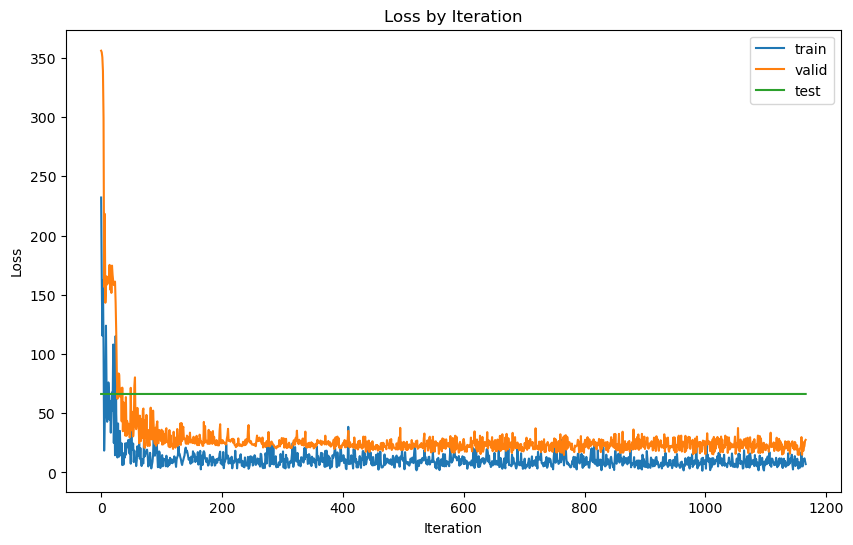

In [107]:
# plot
%matplotlib inline 
plt.figure(figsize=(10,6))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss by Iteration')
plt.plot(torch.tensor(hist_train).detach().cpu())
plt.plot(torch.tensor(hist_valid).detach().cpu())
plt.plot(test_loss.cpu().detach().numpy()*np.ones(len(hist_valid)))
#plt.ylim(5, 10)
plt.legend(['train', 'valid', 'test'])
plt.show()

### Test / Predict compared to the real data

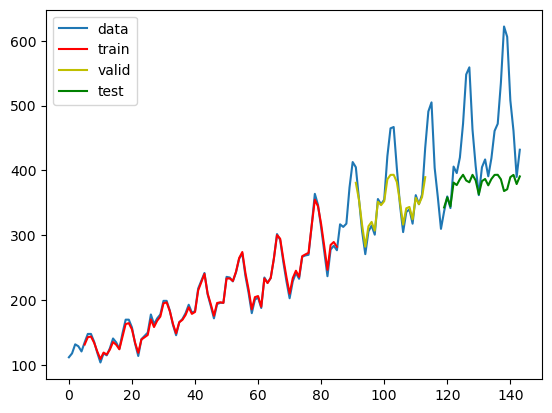

In [108]:
model.eval()
with torch.no_grad():
    # train
    train_plot = (np.ones_like(timeseries) * np.nan)[:,0]
    valid_plot = (np.ones_like(timeseries) * np.nan)[:,0]
    test_plot = (np.ones_like(timeseries) * np.nan)[:,0]

    match Model_Name:
        case "ANN" | "CNN":
                train_plot[lookback:train_size] = model(X_train.to(device))[:,-1].to('cpu')
                valid_plot[train_size+lookback:train_size+valid_size] = model(X_valid.to(device))[:, -1].to('cpu')
                test_plot[train_size+valid_size+lookback:len(timeseries)] = model(X_test.to(device))[:, -1].to('cpu')
        case "LSTM" | "RNN" | "GRU":
            train_plot[lookback:train_size] = model(X_train.to(device))[:, -1, -1].to('cpu')
            valid_plot[train_size+lookback:train_size+valid_size] = model(X_valid.to(device))[:, -1, -1].to('cpu')
            test_plot[train_size+valid_size+lookback:len(timeseries)] = model(X_test.to(device))[:, -1, -1].to('cpu')
        case "T":
            train_plot[lookback:train_size] = model(X_train.to(device),y_train.to(device))[:, -1, -1].to('cpu')    
            valid_plot[train_size+lookback:train_size+valid_size] = model(X_valid.to(device),y_valid.to(device))[:, -1, -1].to('cpu')
            test_plot[train_size+valid_size+lookback:len(timeseries)] = model(X_test.to(device),y_test.to(device))[:, -1, -1].to('cpu')
        case _:
                train_plot[lookback:train_size] = model(X_train.to(device))[:,-1].to('cpu')
                valid_plot[train_size+lookback:train_size+valid_size] = model(X_valid.to(device))[:, -1].to('cpu')
                test_plot[train_size+valid_size+lookback:len(timeseries)] = model(X_test.to(device))[:, -1].to('cpu')

# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(valid_plot, c='y')
plt.plot(test_plot, c='g')
plt.legend(['data','train', 'valid', 'test'])
plt.show()

<div style="text-align: right">Created by Szilárd Kovács</div>